# EMA: Experimental Pipeline <a class="tocSkip">
---
This notebook outlines the commands and methods we used in the paper [Latent variable model for aligning barcoded short-reads improves downstream analyses](https://www.biorxiv.org/content/early/2017/11/16/220236).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Materials" data-toc-modified-id="Materials-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Materials</a></span><ul class="toc-item"><li><span><a href="#Data-samples" data-toc-modified-id="Data-samples-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data samples</a></span></li><li><span><a href="#Tools-and-versions" data-toc-modified-id="Tools-and-versions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tools and versions</a></span></li></ul></li><li><span><a href="#Alignment-pipeline" data-toc-modified-id="Alignment-pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Alignment pipeline</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#EMA" data-toc-modified-id="EMA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EMA</a></span></li><li><span><a href="#Lariat-and-BWA" data-toc-modified-id="Lariat-and-BWA-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Lariat and BWA</a></span></li><li><span><a href="#Post-processing" data-toc-modified-id="Post-processing-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Post-processing</a></span></li><li><span><a href="#Variant-Calling" data-toc-modified-id="Variant-Calling-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Variant Calling</a></span></li><li><span><a href="#Accuracy-Evaluation" data-toc-modified-id="Accuracy-Evaluation-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Accuracy Evaluation</a></span></li></ul></li><li><span><a href="#Phasing-pipeline" data-toc-modified-id="Phasing-pipeline-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Phasing pipeline</a></span></li><li><span><a href="#Evaluation-of-homologous-regions" data-toc-modified-id="Evaluation-of-homologous-regions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation of homologous regions</a></span><ul class="toc-item"><li><span><a href="#Ground-truth-construction" data-toc-modified-id="Ground-truth-construction-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ground truth construction</a></span></li><li><span><a href="#CYP2D6-Copy-Number-Evaluation" data-toc-modified-id="CYP2D6-Copy-Number-Evaluation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><em>CYP2D6</em> Copy Number Evaluation</a></span></li></ul></li><li><span><a href="#How-many-alignments-can-be-improved-by-EMA?" data-toc-modified-id="How-many-alignments-can-be-improved-by-EMA?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>How many alignments can be improved by EMA?</a></span></li><li><span><a href="#Simulations" data-toc-modified-id="Simulations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Simulations</a></span></li><li><span><a href="#Publication-Figures" data-toc-modified-id="Publication-Figures-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Publication Figures</a></span><ul class="toc-item"><li><span><a href="#ROC-plots" data-toc-modified-id="ROC-plots-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>ROC plots</a></span></li><li><span><a href="#False-Positives-and-Negatives" data-toc-modified-id="False-Positives-and-Negatives-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>False Positives and Negatives</a></span></li><li><span><a href="#Statistical-bin-distributions" data-toc-modified-id="Statistical-bin-distributions-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Statistical bin distributions</a></span></li><li><span><a href="#Simulation-data" data-toc-modified-id="Simulation-data-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Simulation data</a></span></li></ul></li></ul></div>

## Materials

### Data samples

The following data samples were used:

| Technology | Individual | Link 
| :--- | :--- | :---:
| 10x | NA12878 | [Download](http://s3-us-west-2.amazonaws.com/10x.files/samples/genome/2.0.0/NA12878_WGS/NA12878_WGS_fastqs.tar) 
| 10x | NA24143 | Available on request
| 10x | NA24149 | Available on request
| 10x | NA24385 | Available on request
| 10x | NA12878 v2 (high coverage) | [Download](http://s3-us-west-2.amazonaws.com/10x.files/samples/genome/2.1.4/NA12878_WGS_v2/NA12878_WGS_v2_fastqs.tar) 
| 10x | NA19238 v2 (high coverage) | [Download](http://s3-us-west-2.amazonaws.com/10x.files/samples/assembly/2.0.0/yorm/yorm_fastqs.tar) 
| 10x | NA19240 v2 (high coverage) | [Download](http://s3-us-west-2.amazonaws.com/10x.files/samples/assembly/2.0.0/yor/yor_fastqs.tar) 
| 10x | NA24385 v2 (high coverage) | [Download](http://s3-us-west-2.amazonaws.com/10x.files/samples/assembly/2.0.0/ash/ash_fastqs.tar) 
| CPT-seq | NA12878 | [NCBI/EBI](https://www.ebi.ac.uk/ena/data/view/SRS665454)
| TruSeq (Moleculo) | NA12878 | [NCBI/EBI](https://www.ebi.ac.uk/ena/data/view/SRX1070739)

Non-10x data was downloaded as:

```bash
# CPT-seq needs -G for barcode reconstruction
fastq-dump SRR1554094 -G -O NA12878

# TruSeq
parallel fastq-dump -F -split-3 ::: SRR2080089 SRR2080145 SRR2080146
parallel python2 fastqsplit.py {} {.} ::: *.fastq
```

In the last example, we used [fastqsplit.py](data/fastqsplit.py) to split the TruSeq FASTQs into the barcoded FASTQs. 

### Tools and versions

The following tools were used:

|Tool      | Version| Link|
|----------|-----|---|
| BWA      | 0.7.15-r1140 | https://github.com/lh3/bwa |
| Sambamba | 0.6.6 | http://lomereiter.github.io/sambamba/ |
| Long Ranger | 2.1.6 | https://support.10xgenomics.com/genome-exome/software/downloads/latest |
| Picard | 2.9.2-SNAPSHOT | https://broadinstitute.github.io/picard/ |
| GATK | 3.8-0-ge9d806836 | https://software.broadinstitute.org/gatk/ |
| LRSIM | 		8abd7c1 | https://github.com/aquaskyline/LRSIM |
| SeqAN |		a0691b9d0 | https://github.com/seqan/seqan |
| HapCUT2 | eb3b64b14b | https://github.com/vibansal/HapCUT2 |
| IGV | 3.0 beta | http://software.broadinstitute.org/software/igv/ |
| Aldy | 1.2 | https://github.com/inumanag/aldy |
| RTG Tools | 3.8.4 | https://github.com/RealTimeGenomics/rtg-tools |
| NIST GIAB | 3.3.2 | http://jimb.stanford.edu/giab/ |
| 10x reference | 2.1.0 | https://support.10xgenomics.com/genome-exome/software/downloads/latest |

We used version 1.0 of the EMA (which was originally v0.0.1 and v0.0.2).

---
## Alignment pipeline

The end-to-end alignment pipeline, genotyping and accuracy evaluation are described here.

### Preprocessing

10x datasets typically come as compressed (e.g. with gzip) interleaved FASTQ files (also with sample index FASTQs which can be ignored for the purposes of EMA). After decompressing, preprocessing can be done as follows. First, generate a barcode counts file (the latest whitelist is available on [our site](http://ema.csail.mit.edu)):

    cat *.fastq | ema count -1 - -w /path/to/whitelist.txt -i -o counts_file

Now we can preprocess the data into a number of barcode *buckets* (specified with `-n`):

    cat *.fastq | ema preproc -1 - -w /path/to/whitelist.txt -c counts_file -n 20

Finally, we can sort each bucket:

    ema sort -1 bucket000/*_1.fastq -2 bucket000/*_2.fastq
    ema sort -1 bucket001/*_1.fastq -2 bucket001/*_2.fastq
    ...
    ema sort -1 bucket019/*_1.fastq -2 bucket019/*_2.fastq

Note that these can all be done in parallel (e.g. with GNU Parallel).

### EMA 

The most straightforward way to run EMA is with the provided wrapper script (`util/ema_wrapper.sh`). For example:

    EMAPATH=/path/to/ema PICARDPATH=/path/to/picard.jar ./ema_wrapper.sh -r /path/to/ref.fa -R '@RG\tID:foo\tSM:bar' -t 20

(`-R` specifies the read group string and `-t` specifies the number of processes to spawn.) Detailed instructions for running EMA in isolation are given [on GitHub](https://github.com/arshajii/ema).

### Lariat and BWA

Lariat is invoked through the Long Ranger pipeline:

    longranger wgs --id=sample --reference=/path/to/10x/ref --fastqs=/path/to/fastqs/ --localcores=48 --localmem=350

Long Ranger will generate an output BAM at `sample/outs/phased_possorted.bam`.

In our experiments, we ran BWA-MEM with default parameters. This can either be done by running BWA-MEM on the raw data, or on the EMA-preprocessed data by modifying `util/ema_wrapper.sh` to invoke BWA-MEM instead of EMA.

### Post-processing

The EMA wrapper script handles post-processing itself, but it basically just comes down to duplicate marking with Picard:

    java -jar /path/to/picard.jar MarkDuplicates I=in.bam O=out.bam M=marked_dup_metrics.txt READ_ONE_BARCODE_TAG=BX READ_TWO_BARCODE_TAG=BX
    
(The `READ_ONE_BARCODE_TAG=BX` and `READ_TWO_BARCODE_TAG=BX` were omitted in the case of BWA-MEM.)

### Variant calling

Variants are called by GATK's HaplotypeCaller with default arguments:

    java -jar /path/to/GenomeAnalysisTK.jar -R /path/to/ref.fa -T HaplotypeCaller -I in.bam -o out.vcf -nct 20
    
### Accuracy evaluation

Genotyping accuracy was determined by RTG Tools. This entails first preprocessing the input VCFs with `bgzip` and `tabix`:

    bgzip in.vcf
    tabix -p vcf in.vcf.gz

Now we can run RTG Tools:

    rtg vcfeval --baseline=/path/to/GIAB_baseline.vcf.gz --evaluation-regions=/path/to/GIAB_regions.bed --calls=in.vcf.gz --output=output_folder --template=/path/to/ref.sdf

(This requires creating an SDF file as in `rtg format -o ref.sdf ref.fa`.)

Final RTG output for 10x data [is located here](data/variants/rtg), while false positives/negatives stats [are here](data/variants/stats).

### Running on TruSeq SLR and CPT-seq data

The current EMA version has a `-p` flag to specify the sequencing platform:

  | Platform | Flag |
  |----------|------|
  | 10x (default) | `-p 10x` |
  | TruSeq SLR | `-p tru` |
  | CPT-seq | `-p cpt` |

---
## Phasing pipeline

In order to evaluate phasing performance, we phased two 10x samples NA12878 and NA24385 with HapCut2. The following VCFs were used as a truth set:

| Name | Link |
|--|--|
| NA12878 | [GIAB download](http://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/NA12878_HG001/latest/GRCh37/HG001_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-X_v.3.3.2_highconf_PGandRTGphasetransfer.vcf.gz) 
| NA24385 | [GIAB download](http://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh37/HG002_GRCh37_GIAB_highconf_CG-IllFB-IllGATKHC-Ion-10X-SOLID_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz) 

In [ ]:
%%bash
# This is the location of HapCUT2's directory
HAPCUT="tools/HapCUT2"

phase() {
    SAMPLE="data/$1"
    TOOL="$2"
    BAM="${SAMPLE}/${TOOL}.bam"
    VCF="${SAMPLE}/${TOOL}.bam"
    mkdir -p data/phase/$SAMPLE
    
    # First extract long-range information from BAM
    time $HAPCUT/build/extractHAIRS \
        --10X 1 \
        --bam $BAM --VCF $VCF \
        --out data/phase/$SAMPLE/${TOOL}.unlink
    time python3 $HAPCUT/utilities/LinkFragments.py \
        --bam $BAM -v $VCF \
        --fragments data/phase/$SAMPLE/${TOOL}.unlink \
        --out data/phase/$SAMPLE/${TOOL}.link
        
    # Then run phasing algorithm
    time $HAPCUT/build/HAPCUT2 --nf 1 \
        --fragments data/phase/$SAMPLE/${TOOL}.link \
        --vcf $VCF \
        --output data/phase/$SAMPLE/${TOOL}.phase
}

# Now run the phasing algorithm
for sample in na12878 na24385 ; do
    for tool in ema lariat ; do
        phase $sample $tool
    done
done

Finally, we compare the HapCUT2's results with the ground truth (stored in `$SAMPLE/giab.vcf`). We slightly modified HapCUT2's [error_rates.py](data/phase/error_rates.py) for our purposes:

In [ ]:
%%bash
for SAMPLE in na12878 na24385; do
    echo "** ${SAMPLE} **:"
    paste <(python data/phase/error_rates.py data/phase/${SAMPLE}/giab.vcf \
            data/phase/${SAMPLE}/ema.phase) \
          <(python data/phase/error_rates.py data/phase/${SAMPLE}/giab.vcf \
            data/phase/${SAMPLE}/lariat.phase) \
      | expand -t 40 \
      | tee data/phase/${SAMPLE}/comparison.txt
done

The output should look like:
    
[NA12878](data/phase/na12878/comparison.txt):
```
dataset:         ema.phase              dataset:         lariat.phase
...
switch errors:   12796                  switch errors:   13001
mismatch errors: 14163                  mismatch errors: 14705
flat errors:     538169                 flat errors:     609858
...
N50:             111392359              N50:             92447569
missed vcf:      769327                 missed vcf:      831048
```

[NA24385](data/phase/na24385/comparison.txt):
```
dataset:         ema.phase              dataset:         lariat.phase
...
switch errors:   10240                  switch errors:   10472
mismatch errors: 14110                  mismatch errors: 14655
flat errors:     377957                 flat errors:     429896
...
N50:             115423711              N50:             115423711
missed vcf:      806856                 missed vcf:      922748
```

---
## Evaluation of homologous regions

In order to evaluate quality of EMA mappings in the "dark" regions of the genome (which are supposedly handled by our statistical binning scheme), we used the following mutations in the highly homologous regions of the genome (hg19):

| Genes   | Region                   | Mutation       |
|---------|--------------------------|----------------|
| AMY1/2  | chr1:104090000-104310000 | chr1:104197843 | 
| C4A/B   | chr6:31940000-32010000   | chr6:31965242  |
| CY2D6/7 | chr22:42521302-42549900  | chr22:42537120 |


### Ground truth construction

We used the following NA12878 assemblies to obtain the "consensus" NA12878 sequence in these regions:

|Type|Link|
|--|--|
| ONT Nanopore Assembly | [Download](http://s3.amazonaws.com/nanopore-human-wgs/canu.35x.contigs.polished2.fasta) |
| PacBio Celera Assembly | [Download](https://bashia02.u.hpc.mssm.edu/NA12878_architecture/data/celera_assembly_quivered.fa.gz) |
| Hybrid (PacBio & Bionano) Assembly  | [Download](https://bashia02.u.hpc.mssm.edu/NA12878_architecture/data/hybrid_scaffold_v2_ends_trimmed.fa.gz) |
| Hybrid (10x, Bionano & WGS) Assembly | [Download](http://kwoklab.ucsf.edu/resources/nmeth_201604_NA12878_hybrid_assembly.fasta.gz) |


For each mutation loci, we pad it with 1kb on both sides, and BLAT the padded region from hg19 (`hg19.fa`) to each assembly. Finally, we extract the best hits from the assemblies in the ground truth FASTA and map it back to the hg19 with BWA-MEM:

In [ ]:
%%bash
samtools faidx hg19.fa chr1:104196843-104198843 chr6:31964242-31966242 chr22:42536120-42549900 > genes.fq
parallel --bar blat {} genes.fq {/.}_genes.psl ::: *.fa

# Get all hits with length >= 1000 and with <= 500 gap bases
rm -rf assembly.fq
for psl in *.psl; do
    `echo -ne "samtools faidx ${psl/_genes.psl/.fa} "
     tail -n+6 $psl | awk '$1 >= 1000 && $8 <= 500 {
            st=$16-1000; if (st<0)  st=0;
            ed=$17+1000; if (ed>$15)ed=$15;
            printf $14":"st"-"ed" "}' $psl
     echo` >> assembly.fq
done

# Map it back to hg19
bwa mem -t4 hg19.fa assembly.fq | samtools sort -Obam -o assembly.bam -
samtools index assembly.bam

Finally, [assembly.bam](data/assembly.bam) contains the consensus sequences for the NA12878 in the given regions. In order to check how well our mappings perform, we load this BAM and the aligner BAM (e.g. `lariat.bam` or `ema.bam`) to IGV and manually evaluate the quality of the alignments in these regions, as in the following example:

<img src="data/igv.png" />

### _CYP2D6_ Copy Number Evaluation

In order to evaluate how well EMA and Lariat perform in highly homologous regions, especially in the presence of copy number variations, we used [Aldy](https://github.com/inumanag/aldy) to find the proper _CYP2D6_ gene CN and genotypes on NA12878 sample. This sample contains copy number aberration (exon 1 in _CYP2D6_ has 3 copies, while other exons and introns have 3 copies in _CYP2D7_, and the correct genotype call is \*3/\*68+\*4 as reported in [Twist et al.](https://www.nature.com/articles/npjgenmed20157)).

The Aldy was ran as follows on input BAMs, and its output was parsed to obtain the difference between the observed CN and the expected CN for all exons and introns in _CYP2D_ cluster. We also separately calculated the same score for a region spanning only exon 7 to exon 9, since this region is almost completely homologous between _2D6_ and _2D7_, and thus is more sensitive to the mapping performance:

In [ ]:
%%bash
for bam in *.bam ; do
    echo ">>> $bam"
    aldy -pillumina $bam

    # Calculate the difference between observed and expected CN 
    # for each proper intron and exon
    # Assume 3/68+4 allelic configuration, which implies
    # CN(2D6)=2 and CN(2D7)=3 (vice versa in exon 1)
    cat ${bam/.bam/.CYP2D6.aldylog} | grep ' : ' | grep -v '0i\|ins\|pce\|rep' | \
        awk '{ if (NR==1){a=$3-3; b=$4-2} else {a=$3-2; b=$4-3}; s+= (a<0?-a:a) + (b<0?-b:b); } END {print "CN difference:", s}'
    # Get the same for problematic regions from e7 (inclusive) to e9 (exclusive)
    cat ${bam/.bam/.CYP2D6.aldylog} | grep ' : ' | grep '7e\|7i\|8e\|8i' | \
        awk '{ if (NR==1){a=$3-3; b=$4-2} else {a=$3-2; b=$4-3};  {s+= (a<0?-a:a) + (b<0?-b:b); print ">>", $0,a,b;}} END {print "CN problematic difference:",s}' ;
done

For the original NA12878 10x sample, the output is:

<pre>
<b>NA12878.orig.ema.genes.bam</b>
*** Aldy v1.2 (Python 2.7.10) ***
Arguments:
  Gene:      CYP2D6
  Profile:   illumina
  Threshold: 50%
  Input:     NA12878.orig.ema.genes.bam
  Phasing:   False
Novel major star-allele (*10-like) found!
Novel major star-allele (*68-like) found!
Novel major star-allele (*3.a-like) found!
Results:
  *3/*10+*68                     (10B+, 3A, 68)
  *3/*10+*68                     (10B, 3A+, 68)
CN difference: 18.99
CN problematic difference: 5.51

<b>NA12878.orig.lariat.genes.bam</b>
...
Novel major star-allele (*10-like) found!
Novel major star-allele (*68-like) found!
Novel major star-allele (*3.a-like) found!
Results:
  *3/*10+*68                     (10B+, 3A, 68)
  *3/*10+*68                     (10B, 3A+, 68)
CN difference: 21.29
CN problematic difference: 8.22
</pre>

Let's consider the EMA's improvement in overall CN score (denoted as _CN difference_ above).
If $l$ stands for Lariat's score, while $e$ stands for EMA's score, we can calculate the improvement as (assuming $e<l$, since larger values of $e$ or $l$ imply larger error):

$100 \cdot \frac{|l-e|}{|l+e|}.$

Thus, EMA's improvement is 5.7%; for the problematic exon 7-exon 9 region the improvement is 19.7% (line _CN problematic difference_). 


Similarly, for high-coverage NA12878 10x sample we get:

<pre>
<b>NA12878.v2.ema.genes.bam</b>
Result:
  *3/*68+*4                      (3A, 4AW, 68)
CN difference: 25.89
CN problematic difference: 7.16

<b>NA12878.v2.lariat.genes.bam</b>
Result:
  *3/*68+*4                      (3A, 4AW, 68)
CN difference: 27.84
CN problematic difference: 8.25
</pre>

Here EMA's improvement is 3.6%; improvement in the problematic region is 7%.

Note that Aldy calls proper CNs in the last sample, while in the original (low coverage) sample it calls \*4 as \*10. This is due to the fact that in low-coverage sample key \*4 SNP is not expressed fully enough to be caught by the set of parameters Aldy uses by default.

Complete Aldy logs are available [here](data/cnv).

---
## How many alignments can be improved by EMA?

The answer is: all those alignments that have multiple possible locations. The simplest way to obtain this number is to count number of reads with multiple alignments, which can be approximated by counting all SAM records with XA tag as follows:

In [ ]:
%%bash
for sample in na12878 na24385 ; do
    echo -ne "${sample}: "
    sambamba view $sample/files/ema_out.bam | \
        awk '{l+=1} /XA:Z:/ {p+=1} END {print p"out of"l}'
done

The result is:
<pre>
NA12878: 159932229 out of 797859887 <b>(20%)</b>
NA24385: 120233799 out of 670830795 <b>(18%)</b>
</pre>

---
## Simulations

We also ran some simulations and compared EMA's performance with that of Lariat and BWA.

First, we obtained chr1 from hg19 and introduced two haplotypes with random variants and SVs via SeqAn's Mason Variator as follows:

In [ ]:
%%bash
mkdir -p ref
curl -L http://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr1.fa.gz | gunzip > ref/chr1.fa
samtools faidx ref/${REF}.fa
bwa index ref/${REF}.fa
$TOOLS/longranger-2.1.6/longranger longranger mkref ref/${REF}.fa
for HAP in A B; do
    $TOOLS/seqan/bin/mason_variator \
        -ir ref/chr1.fa \
        -ov ref/chr1.hap${HAP}.vcf \
        -of ref/chr1.hap${HAP}.fa
done
sed -i '1 s|/1|/2|' ref/chr1.hapB.fa
samtools faidx ref/chr1.fa
bwa index ref/chr1.fa
longranger mkref ref/chr1.fa

Then we simulated reads with LRSIM:

In [ ]:
%%bash
time $TOOLS/LRSIM/simulateLinkedReads.pl \
    -g ref/chr1.hapA.fa,ref/chr1.hapB.fa -1 0 -n -z 20 \
    -p ref/chr1.lrsim -t 125 -f 50 -x 20 -o
mkdir -p fastq
unpigz chr1.lrsim_S1_L00*
mkdir -p fastq/chr1
(paste <(paste - - - - < chr1.lrsim_S1_L001_R1_001.fastq) <(paste - - - - < chr1.lrsim_S1_L001_R2_001.fastq);
 paste <(paste - - - - < chr1.lrsim_S1_L002_R1_001.fastq) <(paste - - - - < chr1.lrsim_S1_L002_R2_001.fastq)) \
    | shuf \
    | tee >(cut -f 1-4 | tr "\t" "\n" > fastq/chr1_lrsim_S0_L001_R1_001.fastq) \
    | cut -f 5-8 | tr "\t" "\n" > fastq/chr1_lrsim_S0_L001_R2_001.fastq
rm -rf chr1.lrsim*

Then we aligned simulated data with our aligners and check how accurate are the mappings with [recalc.py](data/simulations/recalc.py):

In [ ]:
# (1) Lariat / Long Ranger
rm -rf chr1_longranger
$TOOLS/longranger-2.1.6/longranger wgs \
        --id chr1_longranger \
        --fastqs fastq/chr1 \
        --reference ref/refdatachr1\
        --localcores=20 --sex=f 2>&1 
python data/simulations/recalc.py \
        ref/chr1.hapA.vcf \
        ref/chr1.hapB.vcf \
        chr1_longranger/PHASER_SVCALLER_CS/PHASER_SVCALLER/_LINKED_READS_ALIGNER/MERGE_POS_BAM/fork0/files/pos_sorted_bam.bam \
    >chr1_longranger/longranger.misses \
    2> >(tee chr1_longranger/longranger.stats)

# (2) BWA-MEM
rm -rf chr1_bwa
mkdir -p chr1_bwa
bwa mem -t 20 ref/chr1.fa \
    fastq/chr1/chr1_lrsim_S0_L001_R1_001.fastq \
    fastq/chr1/chr1_lrsim_S0_L001_R2_001.fastq \
    >chr1_bwa/initial.sam
sambamba view -S -f bam chr1_bwa/initial.sam \
    | samtools sort -@ 20 -m 20G - -o chr1_bwa/sorted.bam
sambamba index chr1_bwa/sorted.bam
python data/simulations/recalc.py \
        ref/chr1.hapA.vcf \
        ref/chr1.hapB.vcf \
        chr1_bwa/sorted.bam \
    >chr1_bwa/sorted.misses \
    2> >(tee chr1_bwa/sorted.stats)

# (3) EMA
mkdir -p chr1_ema
$TOOLS/ema/util/wrapper2.sh \
    fastq/chr1 \
    chr1_ema \
    ref/chr1.fa \
    '@RG\tID:lrsim\tSM:lrsim' \
    20 \
    chr1
python data/simulations/recalc.py \
        ref/chr1.hapA.vcf \
        ref/chr1.hapB.vcf \
        chr1_ema/ema_out.bam \
    >chr1_ema/ema_out.misses \
    2> >(tee chr1_ema/ema_out.stats)

Final stats are located [here](data/simulations). More useful would be the simulation MAPQ plots generated below.

---
## Publication Figures

The following Python code will generate the plots used in our publication:

In [1]:
# Initialization
import os, re, sys
import cPickle as pickle
from collections import *
import pandas as pd
import numpy as np
import rpy2
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
%load_ext rpy2.ipython
%matplotlib inline

In [ ]:
%%R
library(magrittr)
library(ggplot2)
library(reshape2)
library(cowplot)

### ROC plots

In [8]:
# Load the data
def get_roc_data(sample):
    dx = pd.read_table("data/variants/roc/{}/ema.tsv".format(sample), skiprows=[0,1,2,3,4], sep='\t')
    dy = pd.read_table("data/variants/roc/{}/lr.tsv".format(sample), skiprows=[0,1,2,3,4], sep='\t')
    dz = pd.read_table("data/variants/roc/{}/bwa.tsv".format(sample), skiprows=[0,1,2,3,4], sep='\t')
    dx = pd.concat([dx, dy, dz], keys=['EMA', 'Lariat', 'BWA-MEM']).reset_index()
    dx['thick'] = 1
    dx.loc[dx.level_0 == 'EMA', 'thick'] = 1
    return dx.rename(columns={'level_0': 'Tool'})
roc1 = get_roc_data('NA12878')
roc2 = get_roc_data('NA24385')

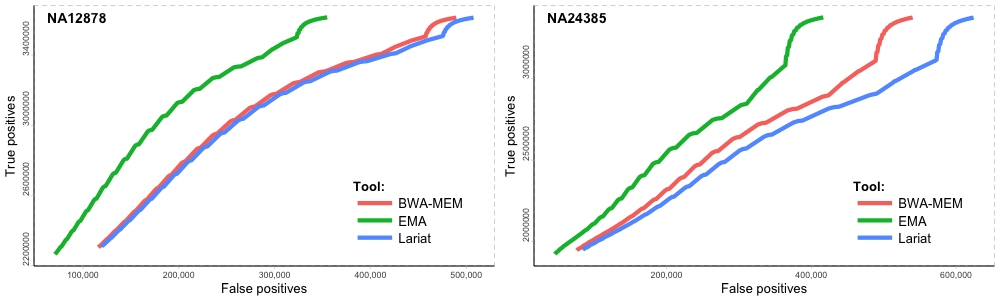

In [18]:
%%R -i roc1 -i roc2 -w 1000 -h 300
# Plot the data
plot_roc <- function(x) ggplot(x, aes(x=false_positives, y=true_positives_call)) +
    geom_line(aes(group=Tool, color=Tool), size=2) +
    theme(legend.position="none") + theme_light() + 
    scale_x_continuous(labels = scales::comma) +
    xlab("False positives") + ylab("True positives") + 
    labs(colour="Tool:") +
    guides(colour = guide_legend(override.aes=list(size=2))) +
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          panel.border = element_rect(linetype="dashed", fill = NA),
          axis.line = element_line(colour="black"),
          axis.title.y = element_text(size=13), 
          axis.title.x = element_text(size=13), 
          axis.text.y = element_text(angle=90, hjust=0), 
          legend.position = c(.95, .35),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6), 
          legend.key.width = unit(3, "line"), 
          legend.title = element_text(size=13, face="bold"), 
          legend.text = element_text(size=13))
plot_grid(
    roc1 %>% plot_roc(),
    roc2 %>% plot_roc(),
    align='h',
    labels=c('NA12878', 'NA24385'),
    hjust=-0.8, vjust=2.2)

### False Positives and Negatives

In [6]:
# Fetch the data
def get_fp_data(sample):
    MAXCHR = 250000000
    BINSZ = 100000
    def get_df(loc):
        def bin(loc):
            bins = range(0, MAXCHR, BINSZ)
            dn = pd.read_table(loc, header=None, names=None).sort_values(by=[0])
            dn['bins'] = np.digitize(dn[0], bins)
            dd = dn.groupby('bins').count().to_dict()[0]
            for b in xrange(0, MAXCHR / BINSZ):
                if b not in dd: dd[b] = 0
            return pd.DataFrame.from_dict({0: dd}).sort_index()
        dn = bin("data/variants/stats/{}_fn.txt".format(loc))
        dp = bin("data/variants/stats/{}_fp.txt".format(loc))
        dd = pd.merge(dn, dp, left_index=True, right_index=True, how='outer', suffixes=['_n', '_p']).fillna(0)
        dd['0_n'] = dd['0_n'].cumsum()
        dd['0_p'] = dd['0_p'].cumsum()
        dd['baseline'] = 0
        return dd.rename(columns={'0_n': 'fn', '0_p': 'fp'})
    de = get_df("{}_ema".format(sample))
    dn = get_df("{}_lr".format(sample))
    dx = pd.concat([dn, de], keys=['0', '1']).reset_index()
    return dx.rename(columns={'level_0': 'tool', 'level_1': 'index'})
fp1 = get_fp_data("na12878")
fp2 = get_fp_data("na24385")

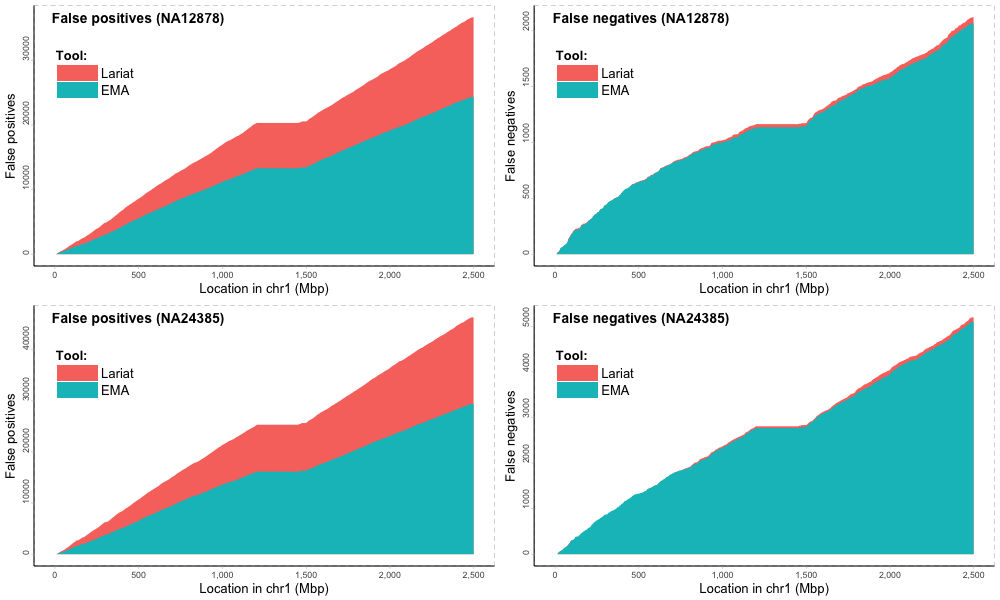

In [8]:
%%R -i fp1 -i fp2 -w 1000 -h 600
plot_fp <- function(x, row, title) ggplot(x, aes(x=index)) +
    geom_ribbon(aes_string(ymin='baseline', ymax=row, fill='tool'), alpha=1) +
    xlab("Location in chr1 (Mbp)") + ylab(title) +
    scale_x_continuous(labels = scales::comma) +
    scale_fill_discrete(name="Tool:",
                         breaks=c(0,1),
                         labels=c("Lariat", "EMA")) +
    guides(colour = guide_legend(override.aes = list(size=2))) +
    theme_light()  +
    theme(legend.position = c(.23, .85),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6), 
          legend.key.width=unit(3, "line"), 
          legend.title = element_text(size=13, face="bold"), 
          legend.text = element_text(size=13), 
          axis.title.y = element_text(size = 13), 
          axis.title.x = element_text(size = 13), 
          axis.text.y = element_text(angle=90, hjust=0),
          panel.border = element_rect(linetype = "dashed", fill = NA),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          axis.line = element_line(colour = "black"))
plot_grid(
    plot_fp(fp1, "fp", "False positives"),
    plot_fp(fp1, "fn", "False negatives"),
    plot_fp(fp2, "fp", "False positives"),
    plot_fp(fp2, "fn", "False negatives"),
    align='h',
    labels=c(
        'False positives (NA12878)', 'False negatives (NA12878)',
        'False positives (NA24385)', 'False negatives (NA24385)'),
    hjust=-.3, vjust=2.2)

### Statistical bin distributions

Each distribution (data is in CSV format) is generated via [bindist.py](data/bindist/bindist.py) as follows:

In [ ]:
%%bash
python2 bindist.py file.bam dist.csv

This script requires EMA-mapped file (because it uses XC tags unique to EMA to consider only those clouds which are **NOT** subject to statistical binning) and is not very fast (takes ~1hr on whole human BAM). At the end it generates `dist.csv` used by the following Python plotting routine:

In [9]:
# Load the data
data = pd.DataFrame()
for si, sample in enumerate(['na12878', 'na24385']): # + ['initial']
    dbins = pd.read_csv('data/bindist/10x-' + sample + '.csv')
    dbins = dbins.iloc[1:,].melt(id_vars=['index'], value_vars=map(str, range(300)))
    dbins['sample'] = '[{}] {} (10x)'.format(si + 1, sample.upper())
    data = data.append(dbins)

dbins = pd.read_csv('data/bindist/moleculo-na12878.csv')
dbins = dbins.iloc[1:,].melt(id_vars=['index'], value_vars=map(str, range(300)))
dbins['sample'] = '[3] NA12878 (TruSeq)'
data = data.append(dbins)

dbins = pd.read_csv('data/bindist/cptseq-na12878.csv')
dbins = dbins.iloc[1:,].melt(id_vars=['index'], value_vars=map(str, range(300)))
dbins['sample'] = '[4] NA12878 (CPT-seq)'
data = data.append(dbins)

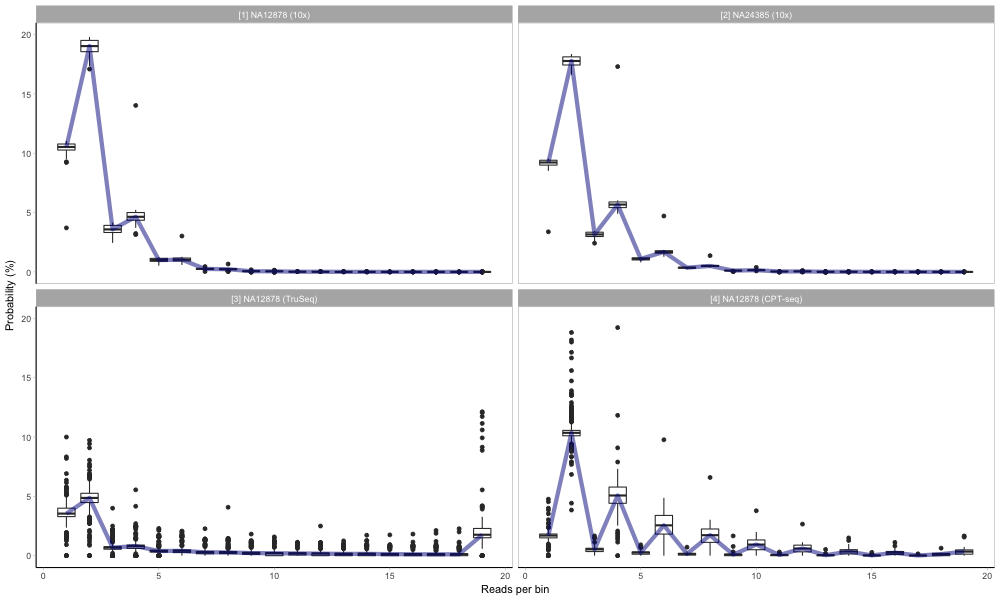

In [11]:
%%R -i data -w 1000 -h 600
# Plot it!
ggplot(data, aes(x=index,y=value)) +
    geom_boxplot(aes(group=index)) +
    stat_summary(fun.y=median, colour="darkblue", alpha=.5, geom="line", size=2) +
    facet_wrap(~sample) +
    theme(legend.position="none") + theme_light()  + ylim(0,20) +
    xlab("Reads per bin") + ylab("Probability (%)") + 
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          axis.line = element_line(colour = "black"))

### Simulation data

The following code plots the corelation between MAPQs and the correct alignments based on simulated data:

In [12]:
#%% Load MAPQ data
def load_mapq_data(sample):
    dx = pd.read_table("data/simulations/{}_ema.stats".format(sample), skiprows=[0,1,2,64], sep=' ', names='bin ok total perc'.split())
    dy = pd.read_table("data/simulations/{}_lariat.stats".format(sample), skiprows=[0,1,2,64], sep=' ', names='bin ok total perc'.split())
    dz = pd.read_table("data/simulations/{}_bwa.stats".format(sample), skiprows=[0,1,2,64], sep=' ', names='bin ok total perc'.split())
    dz.sample()
    def parse(dx):
        dx['cum'] = dx.total.cumsum()
        dx['cumerr'] = dx.total.cumsum() - dx.ok.cumsum()
        return dx
    dx, dy, dz = map(parse, [dx, dy, dz])
    dx = pd.concat([dx, dy, dz], keys=['EMA', 'Lariat', 'BWA-MEM']).reset_index()
    dx['thick'] = 1
    dx.loc[dx.level_0 == 'EMA', 'thick'] = 2
    return dx.rename(columns={'level_0': 'Tool'})
mapq = load_mapq_data('chr1')

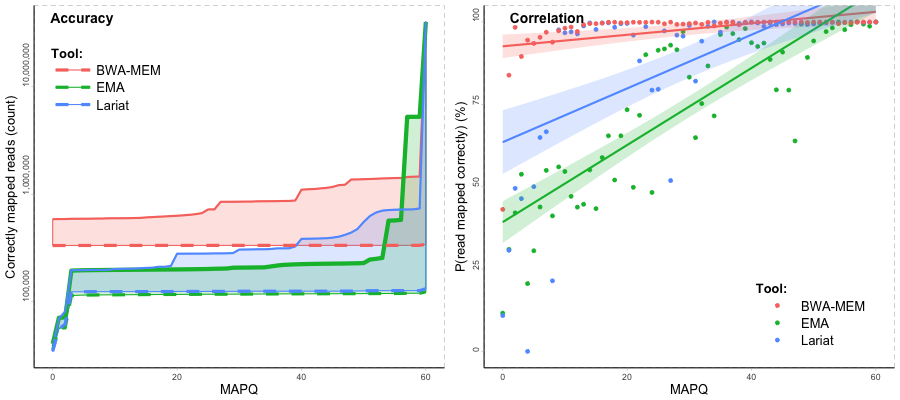

In [13]:
%%R -i mapq -w 900 -h 400
q1 <- ggplot(mapq, aes(x=bin, group=Tool, colour=Tool)) +
    geom_ribbon(aes(ymax=cum, ymin=cumerr, fill=Tool), alpha=.2, show.legend = F) +
    geom_line(aes(y=cum, size=thick)) +
    geom_line(aes(y=cumerr), linetype = 'dashed', size=1.5) +
    scale_size(range = c(1, 2), guide="none") +
    scale_y_log10(labels = scales::comma) +
    theme(legend.position="none") + theme_light()  + # ylim(0,20) +
    xlab("MAPQ") + ylab("Correctly mapped reads (count)") + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    theme(legend.title = element_text(face = "bold"), panel.border = element_rect(linetype = "dashed", fill = NA))  + labs(colour="Tool:") +
    theme(legend.position = c(.33, .90),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6), legend.key.width=unit(3, "line"), legend.title = element_text(size=13), legend.text=element_text(size=13), axis.title.y = element_text(size = 13), axis.title.x = element_text(size = 13), axis.text.y = element_text(angle=90, hjust=0))
q2 <- ggplot(mapq, aes(x=bin, y=perc)) +
    geom_point(aes(group=Tool, colour=Tool)) + geom_smooth(aes(colour=Tool, fill=Tool), method="lm", alpha=0.2, show.legend=F) +
    coord_cartesian(ylim = c(0,100)) +
    theme(legend.position="none") + theme_light()  + # ylim(0,20) +
    xlab("MAPQ") + ylab("P(read mapped correctly) (%)") + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    theme(legend.title = element_text(face = "bold"), panel.border = element_rect(linetype = "dashed", fill = NA))  + labs(colour="Tool:") +
    theme(legend.position = c(.95, .25),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6), legend.key.width=unit(3, "line"), legend.title = element_text(size=13), legend.text=element_text(size=13), axis.title.y = element_text(size = 13), axis.title.x = element_text(size = 13), axis.text.y = element_text(angle=90, hjust=0))
plot_grid(q1, q2,
    align='h',
    labels=c('Accuracy', 'Correlation'),
    hjust=-0.8, vjust=2.2)